# AlexNet

Outline
- Introduction
- Model Definition
- Weight Initialisations
- Training
- Results

In [31]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
from torchvision import models

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms


# Image display
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix imports
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary
import shutil
import math
from IPython import display

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Introduction

In this jupyter notebook we will be implementing a flavour of [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), which was the winner of [ImageNet Challenge](https://image-net.org/challenges/LSVRC/) in 2012. Before moving forward, we should look at the dataset we will using for this excercise. 

### CIFAR10
This dataset consists of 60K 32x32 RGB images, with 6K images per class. These classes are: airplane, bird, cat, dog, frog, horse, ship, truck.

In [2]:
# Repeatability of results
torch.manual_seed(1)

# We want to train our model on a hardware accelerator like the GPU, if it is available.
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

# The number of images in a mini-batch
batch_size = 64

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

Using cuda device


In [3]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)

test_set = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

n_train = int(len(training_set) * 0.9)
n_valid = len(training_set) - n_train
train_set, validation_set = data.random_split(training_set, [n_train, n_valid])

Files already downloaded and verified
Files already downloaded and verified


In [25]:
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_set, **test_kwargs)

# print the dataset
print(f'Size of training set = {len(train_set)}')
print(f'Size of validation set = {len(validation_set)}')
print(f'Size of test set = {len(test_set)}')
# print for dataset loader
print(f'Size of train loader = {len(train_loader)}') # ceil(len(training_set) / batch_size)
print(f'Size of validation loader = {len(validation_loader)}')
print(f'Size of test loader = {len(test_loader)}')

Size of training set = 45000
Size of validation set = 5000
Size of test set = 10000
Size of train loader = 704
Size of validation loader = 79
Size of test loader = 157


One Batch Dimension = torch.Size([64, 3, 32, 32]), Labels Dimension = torch.Size([64])


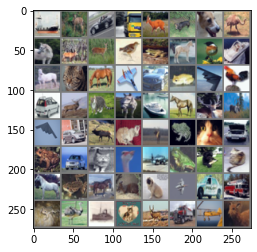

In [30]:
# Helper function for inline image display
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def matplotlib_imshow(img):
    img = normalize_image(img)
    img = img.permute((1,2,0))
    npimg = img.numpy()
    plt.imshow(npimg)
    
# Extract a batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(f'One Batch Dimension = {images.shape}, Labels Dimension = {labels.shape}')

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)

# Default log_dir argument is "runs" - but it's good to be specific
shutil.rmtree('runs/cifar10_experiment_1')
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/cifar10_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image(f'{batch_size} CIFAR10 Images', img_grid)


In [6]:
# Run "tensorboard --logdir runs/cifar10_experiment_1" on a separate terminal and follow the generated
# IP address to view tensorboard results

## Model Definition
This model has two parts: feature extractor and classifier. The model has 8 layers, 5 convolutional and 3 fully connected layers. 

In [7]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 *2 *2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim)
        )
        
    def forward(self, x):
        x = self.features(x)
        f = x.view(x.shape[0], -1)
        x = self.classifier(f)
        return x, f

output_dim = 10
net = AlexNet(output_dim).to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
         MaxPool2d-2             [-1, 64, 8, 8]               0
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,784
         MaxPool2d-5            [-1, 192, 4, 4]               0
              ReLU-6            [-1, 192, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         590,080
        MaxPool2d-12            [-1, 256, 2, 2]               0
             ReLU-13            [-1, 256, 2, 2]               0
          Dropout-14                 [-

## Weight Initialisations
In some cases, setting the initial weights can help get better performances. There are multiple normal distributiosn with varying standard deviations from which we can select these weights. One such example is given below. The `apply` function will call this method with-in every module and submodule of this network.

In [8]:
def parameter_initialisation(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight.data, nonlinearity='relu')
        nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(layer.bias.data, 0)

In [9]:
net.apply(parameter_initialisation)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

## Training
We will train the AlexNet, on CIFAR10 dataset and after each epoch will evaluate the trained model on the validation set. 

In [35]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [11]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [32]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(inputs)
        loss = criterion(y_pred, labels)
        acc = calculate_accuracy(y_pred, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        running_loss += loss.item()
        if (batch_idx+1) % 200 == 0:
            writer.add_scalar('Training_loss', running_loss,(epoch * len(train_loader) + batch_idx)*batch_size)
            running_loss = 0.0
    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [33]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            y_pred,_ = model(data)
            loss = criterion(y_pred, target) 
            acc = calculate_accuracy(y_pred, target)
            test_loss += loss.item()
            test_acc += acc.item()
    n_iter = epoch * len(test_loader) * batch_size
    writer.add_scalar('Testing loss', test_loss, n_iter)
    return test_loss / len(test_loader), test_acc / len(test_loader)

In [34]:
EPOCHS = 25
for epoch in range(0,EPOCHS):
    train_loss, train_acc = train(net, train_loader, optimizer, criterion)
    valid_loss, valid_acc = test(net, validation_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Epoch: 01
	Train Loss: 0.173 | Train Acc: 95.00%
	 Val. Loss: 1.447 |  Val. Acc: 70.35%
Epoch: 02
	Train Loss: 0.146 | Train Acc: 95.68%
	 Val. Loss: 1.558 |  Val. Acc: 71.38%
Epoch: 03
	Train Loss: 0.158 | Train Acc: 95.60%
	 Val. Loss: 1.468 |  Val. Acc: 70.55%
Epoch: 04
	Train Loss: 0.161 | Train Acc: 95.47%
	 Val. Loss: 1.391 |  Val. Acc: 70.17%
Epoch: 05
	Train Loss: 0.141 | Train Acc: 95.92%
	 Val. Loss: 1.539 |  Val. Acc: 69.98%
Epoch: 06
	Train Loss: 0.159 | Train Acc: 95.63%
	 Val. Loss: 1.511 |  Val. Acc: 71.12%
Epoch: 07
	Train Loss: 0.143 | Train Acc: 96.00%
	 Val. Loss: 1.357 |  Val. Acc: 70.69%
Epoch: 08
	Train Loss: 0.143 | Train Acc: 96.07%
	 Val. Loss: 1.676 |  Val. Acc: 69.90%
Epoch: 09
	Train Loss: 0.119 | Train Acc: 96.69%
	 Val. Loss: 1.612 |  Val. Acc: 70.53%
Epoch: 10
	Train Loss: 0.152 | Train Acc: 95.94%
	 Val. Loss: 1.467 |  Val. Acc: 70.11%
Epoch: 11
	Train Loss: 0.151 | Train Acc: 96.05%
	 Val. Loss: 1.634 |  Val. Acc: 70.41%
Epoch: 12
	Train Loss: 0.144 | T

## Results
Now we will examine the trained model. First, we will plot the confusion matrix.

In [36]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [37]:
images, labels, probs = get_predictions(net, test_loader, device)
pred_labels = torch.argmax(probs, 1)

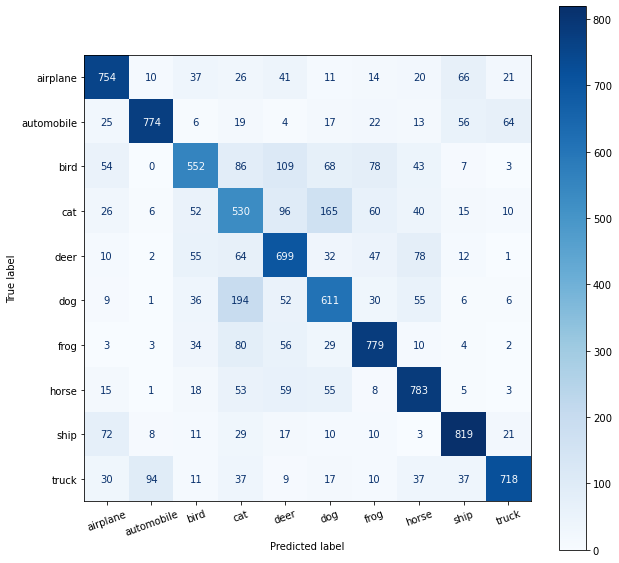

In [38]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
        'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)
    
plot_confusion_matrix(labels, pred_labels, classes)

The trained model looks confused between a cat and dog. Now, lets plot the most confident incorrect predictions. 

In [39]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [41]:
def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(15, 15))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        image = image.permute(1,2,0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]
        image = normalize_image(image)
        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} \n'
                     f'pred label: {incorrect_class} ')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.4)

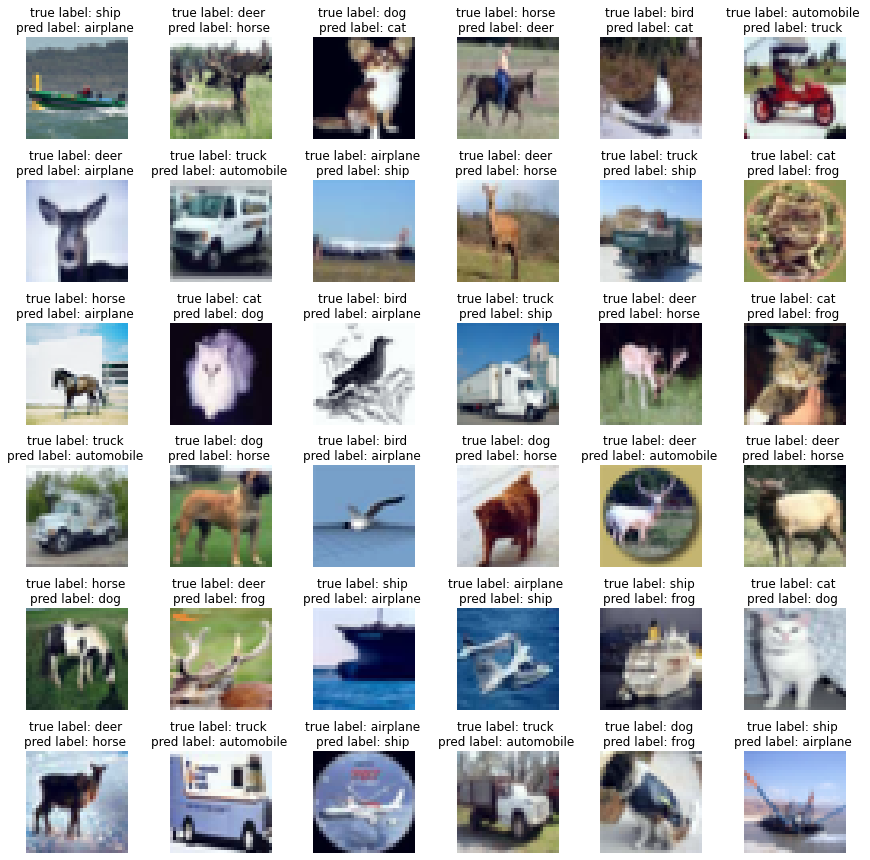

In [42]:
n_images = 36
plot_most_incorrect(incorrect_examples, n_images)

### Feature projection into lower dimensions

The features are higher dimensional vectors which divide different object classes into a set of clusters. For the current model, the each feature has a length of 1024. Let's plot these feature vectors using PCA and see if we get a clusters of different objects.  

In [43]:
def get_representations(model, iterator, device):
    model.eval()
    outputs = []
    features = []
    labels = []
    images = []
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(iterator):
            x = x.to(device)
            y_pred, f = model(x)
            outputs.append(y_pred.cpu())
            features.append(f.cpu())
            labels.append(y)
            x = normalize_image(x)
            images.append(x)
    outputs = torch.cat(outputs, dim=0)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    images = torch.cat(images, dim=0)
    return outputs, features, labels, images


outputs, intermediates, labels, images = get_representations(net, test_loader, device)

class_labels = [classes[label] for label in labels]
writer.add_embedding(intermediates, metadata = class_labels, label_img = images)
writer.flush()

### Weights Visualisations
The pre-trained model of AlexNet, trained on ImageNet can be used for visualisations. The model that we used was not trained to its full power and with a large dataset. The pre-trained AlexNet have different layer conifguration than what we have above.

In [44]:
model = models.alexnet(pretrained=True)
print(model)
model = model.to(device)
summary(model, (3,256,256))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

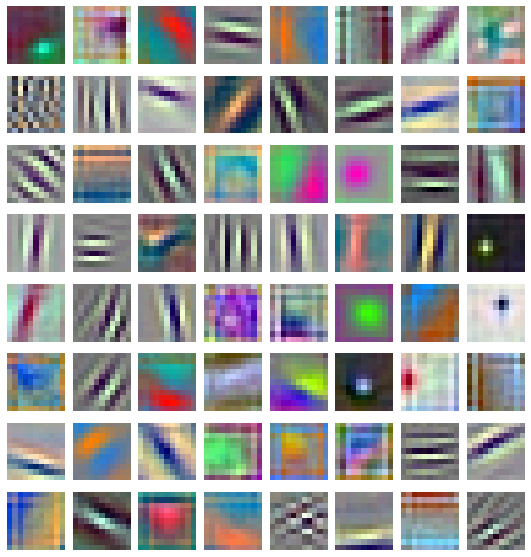

In [45]:
def plot_filters(filters):
    filters = filters.cpu()
    n_filters = filters.shape[0]
    cell_size = int(np.sqrt(n_filters))
    fig = plt.figure(figsize=(20, 10))
    for i in range(cell_size*cell_size):
        image = filters[i]
        image = normalize_image(image)
        ax = fig.add_subplot(cell_size, cell_size, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
    fig.subplots_adjust(wspace=-0.9)
filters = model.features[0].weight.data
plot_filters(filters)